# Code for training model

## Set the path and name

In [1]:
# Pour le training set
datasetFolderPath = "dataset_tip" # path of the dataset folder
labelme_folder_path_train = datasetFolderPath + "\\train" # chemin du dossier ou sont enregistre les images annotees avec labelme
coco_path_train = datasetFolderPath + "\\train.json" # output path

# Et pour le validation set
labelme_folder_path_val = datasetFolderPath + "\\val"
coco_path_val = datasetFolderPath + "\\val.json"


# output directody where save the model
outDirModel = "Models_3classes_tip"



## Import librairies

In [2]:
# Import Libraries:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.data import transforms as T
# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt
import yaml, copy

# import some common detectron2 utilities
from detectron2 import model_zoo, structures
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.utils.visualizer import ColorMode


import labelme2cocoMy

c:\Users\faraboli\AppData\Local\miniconda3\envs\bubbleid\lib\site-packages\detectron2\model_zoo\model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# Si on modifie les fichiers importer il faut forcer a les recharger pour que les modifs soient prises en compte
from importlib import reload
reload(labelme2cocoMy)

<module 'labelme2cocoMy' from 'c:\\Users\\faraboli\\Desktop\\BubbleID\\BubbleIDGit\\ProjetBubbleID\\training\\labelme2cocoMy.py'>

## Creation du fichier coco a partir des sorties de labelme

In [4]:
# Pour le training set
labelme2cocoMy.labelme2coco(labelme_folder_path_train, coco_path_train)
# Et pour le validation set
labelme2cocoMy.labelme2coco(labelme_folder_path_val, coco_path_val)

Conversion terminée : 220 images, 2255 annotations
Classes retenues : ['attached', 'detached', 'occludedAttached']
Conversion terminée : 56 images, 577 annotations
Classes retenues : ['attached', 'detached', 'occludedAttached']


In [5]:
# OPTION: pour verifier le nombre de classe et leur numerotation
import json

with open(coco_path_train) as f:
    data = json.load(f)
num_classes = len(data["categories"])
print("Nombre de classes dans JSON COCO:", num_classes)
for c in data["categories"]:
    print(c["id"], c["name"])

Nombre de classes dans JSON COCO: 3
1 attached
2 detached
3 occludedAttached


In [6]:
register_coco_instances("my_dataset_train", {}, coco_path_train, labelme_folder_path_train)
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

register_coco_instances("my_dataset_test", {}, coco_path_val, labelme_folder_path_val)
val_metadata = MetadataCatalog.get("my_dataset_test")
val_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[10/15 09:44:44 d2.data.datasets.coco]: Loaded 220 images in COCO format from dataset_tip\train.json
[10/15 09:44:44 d2.data.datasets.coco]: Loaded 56 images in COCO format from dataset_tip\val.json


Si un warning apparait c'est en general car certain label on ete fait avec circle sur labelme. Dans ce cas il faut convertir les cercles en polygone avec la fonction circle2Polygon, puis refaire le fichier coco (rerun les cellules ci dessus)

Une erreur peut aussi apparaitre si on a pas restart le kernel et les "my_dataset_" sont deja existant. Dans ce cas il faut les supprimer au prealable:

In [7]:
# for d in ["my_dataset_train", "my_dataset_test"]:
#     if d in DatasetCatalog.list():
#         DatasetCatalog.remove(d)
#     if d in MetadataCatalog.list():
#         MetadataCatalog.remove(d)

### Visualisation des images avec annotations

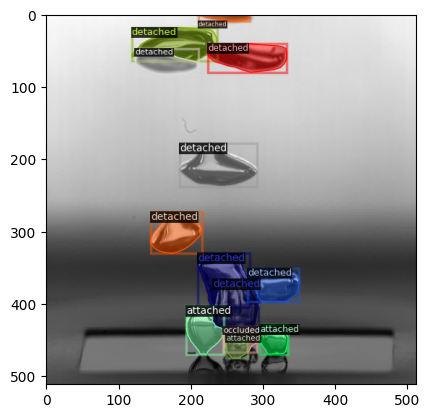

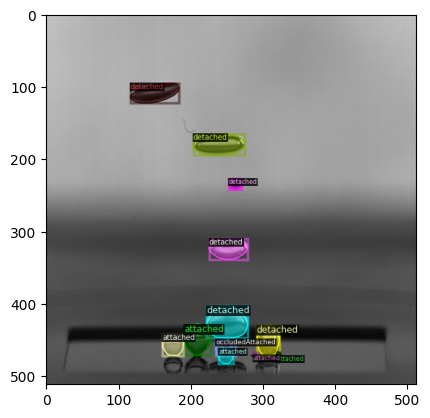

In [8]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

## Parametres pour le training

In [9]:
cfg = get_cfg()
cfg.OUTPUT_DIR = outDirModel
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_MATLAB1.pth")  # path to the model we just trained
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # NOTE !!!!!! il faut modifier ce parametre en fonction du nombre de classe
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
#trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


In [10]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    mean = 0
    std_dev = 25
    gaussian_noise = np.random.normal(mean, std_dev, image.shape).astype(np.uint8)
    #noisy_image = cv2.add(image, gaussian_noise)
    
    transform_list = [
        #T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        #T.RandomRotation(angle=[90, 90]),
        #T.RandomNoise(mean=0.0, std=0.1),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

trainer=CustomTrainer(cfg)
trainer.resume_or_load(resume=False)

[10/15 09:44:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

## Start the training process

In [11]:
trainer.train()

[10/15 09:44:46 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\faraboli\AppData\Local\miniconda3\envs\bubbleid\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/15 09:44:59 d2.utils.events]:  eta: 0:07:04  iter: 19  total_loss: 3.703  loss_cls: 1.407  loss_box_reg: 0.8657  loss_mask: 0.6883  loss_rpn_cls: 0.6677  loss_rpn_loc: 0.1017    time: 0.4321  last_time: 0.4293  data_time: 0.1918  last_data_time: 0.0040   lr: 4.9953e-06  max_mem: 2310M
[10/15 09:45:08 d2.utils.events]:  eta: 0:06:52  iter: 39  total_loss: 3.202  loss_cls: 1.336  loss_box_reg: 0.8829  loss_mask: 0.6789  loss_rpn_cls: 0.2654  loss_rpn_loc: 0.05095    time: 0.4306  last_time: 0.4303  data_time: 0.0042  last_data_time: 0.0035   lr: 9.9902e-06  max_mem: 2312M
[10/15 09:45:16 d2.utils.events]:  eta: 0:06:43  iter: 59  total_loss: 2.983  loss_cls: 1.187  loss_box_reg: 0.8953  loss_mask: 0.6577  loss_rpn_cls: 0.1454  loss_rpn_loc: 0.05388    time: 0.4302  last_time: 0.4285  data_time: 0.0044  last_data_time: 0.0049   lr: 1.4985e-05  max_mem: 2312M
[10/15 09:45:25 d2.utils.events]:  eta: 0:06:35  iter: 79  total_loss: 2.703  loss_cls: 1.007  loss_box_reg: 0.8634  loss_mask: 

## Save the config to a config.yaml file

In [12]:
config_yaml_path = os.path.join(outDirModel, "config.yaml")
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Test the model

[10/15 09:52:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Models_3classes_tip\model_final.pth ...


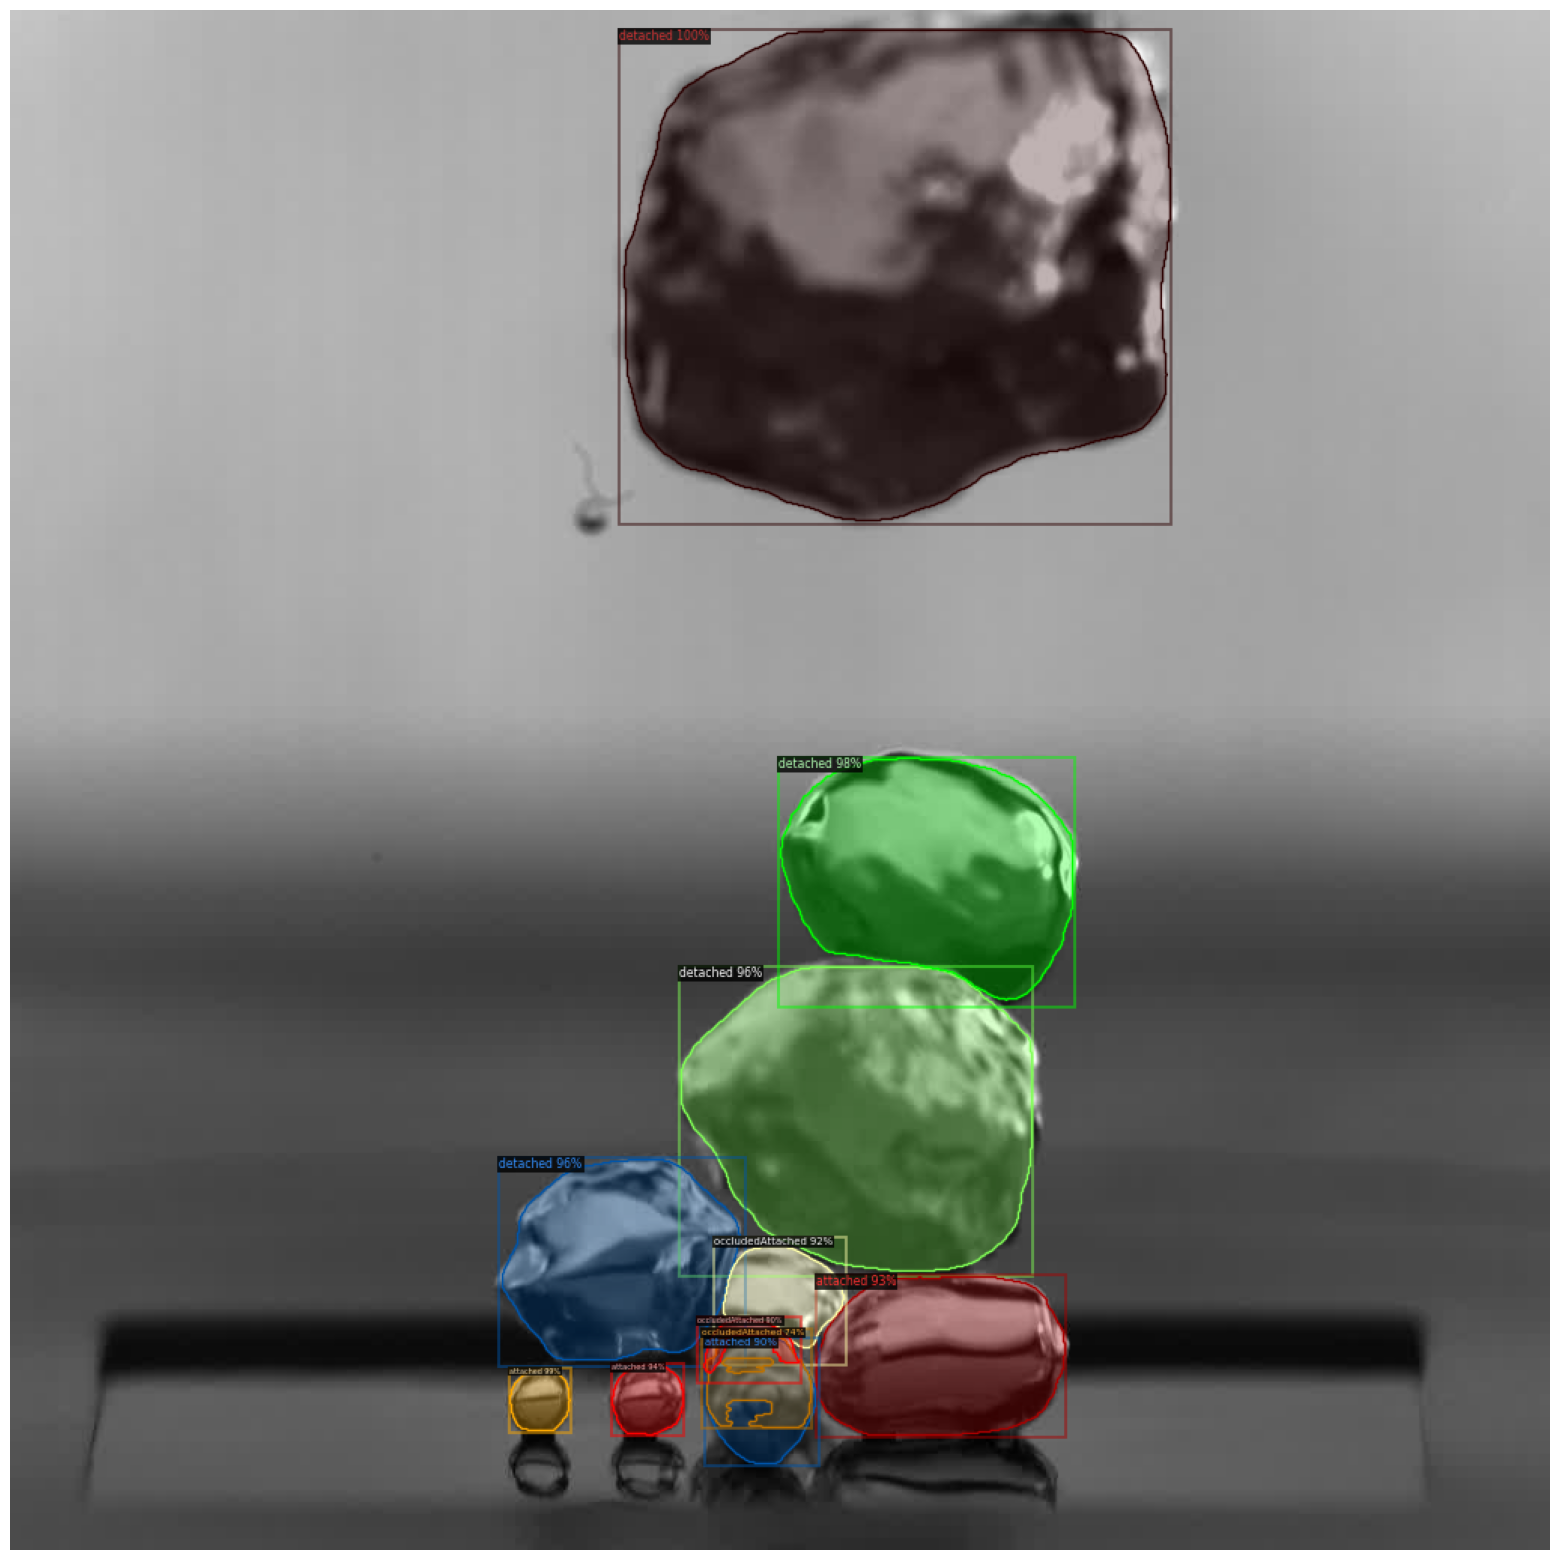

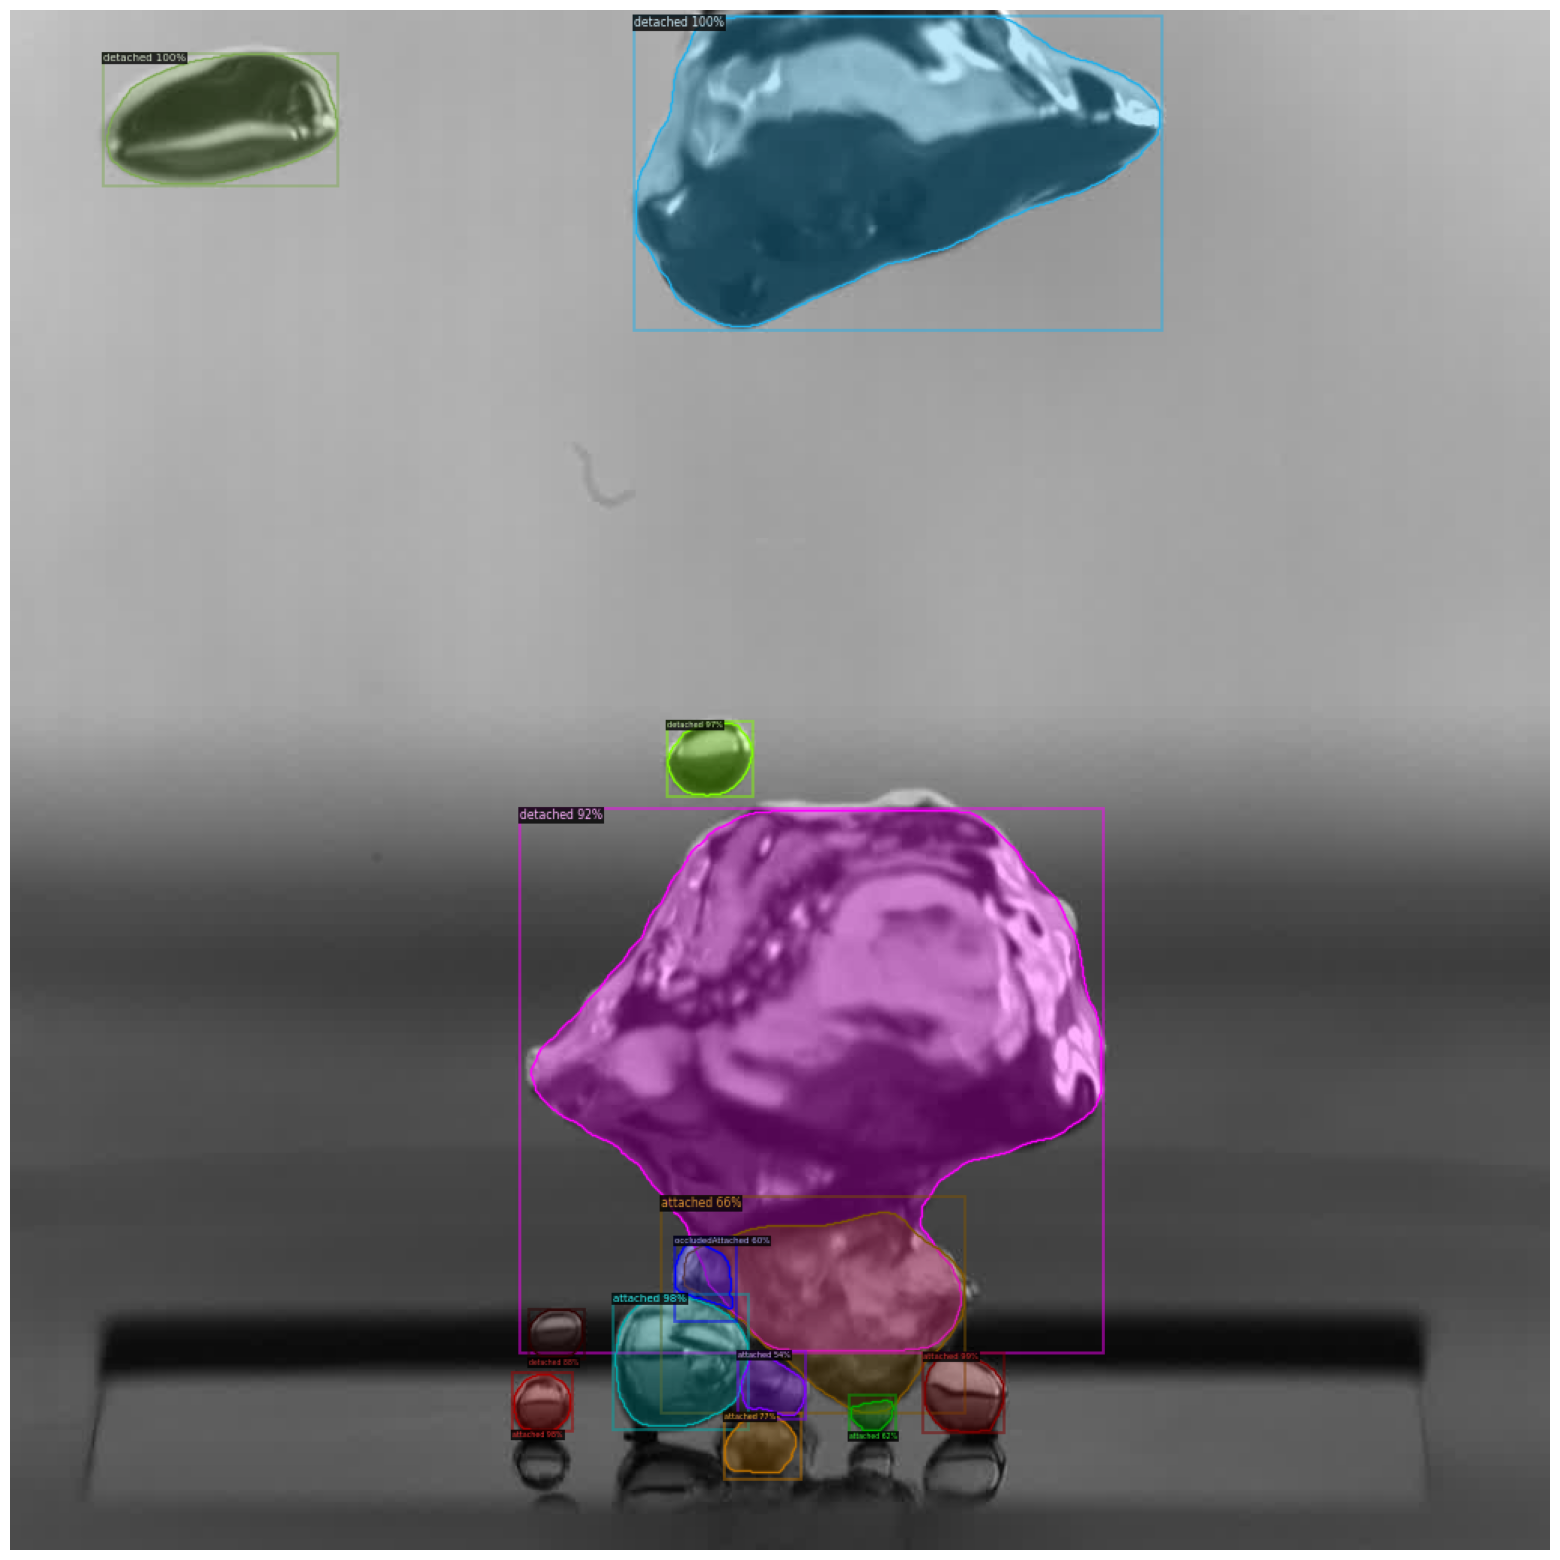

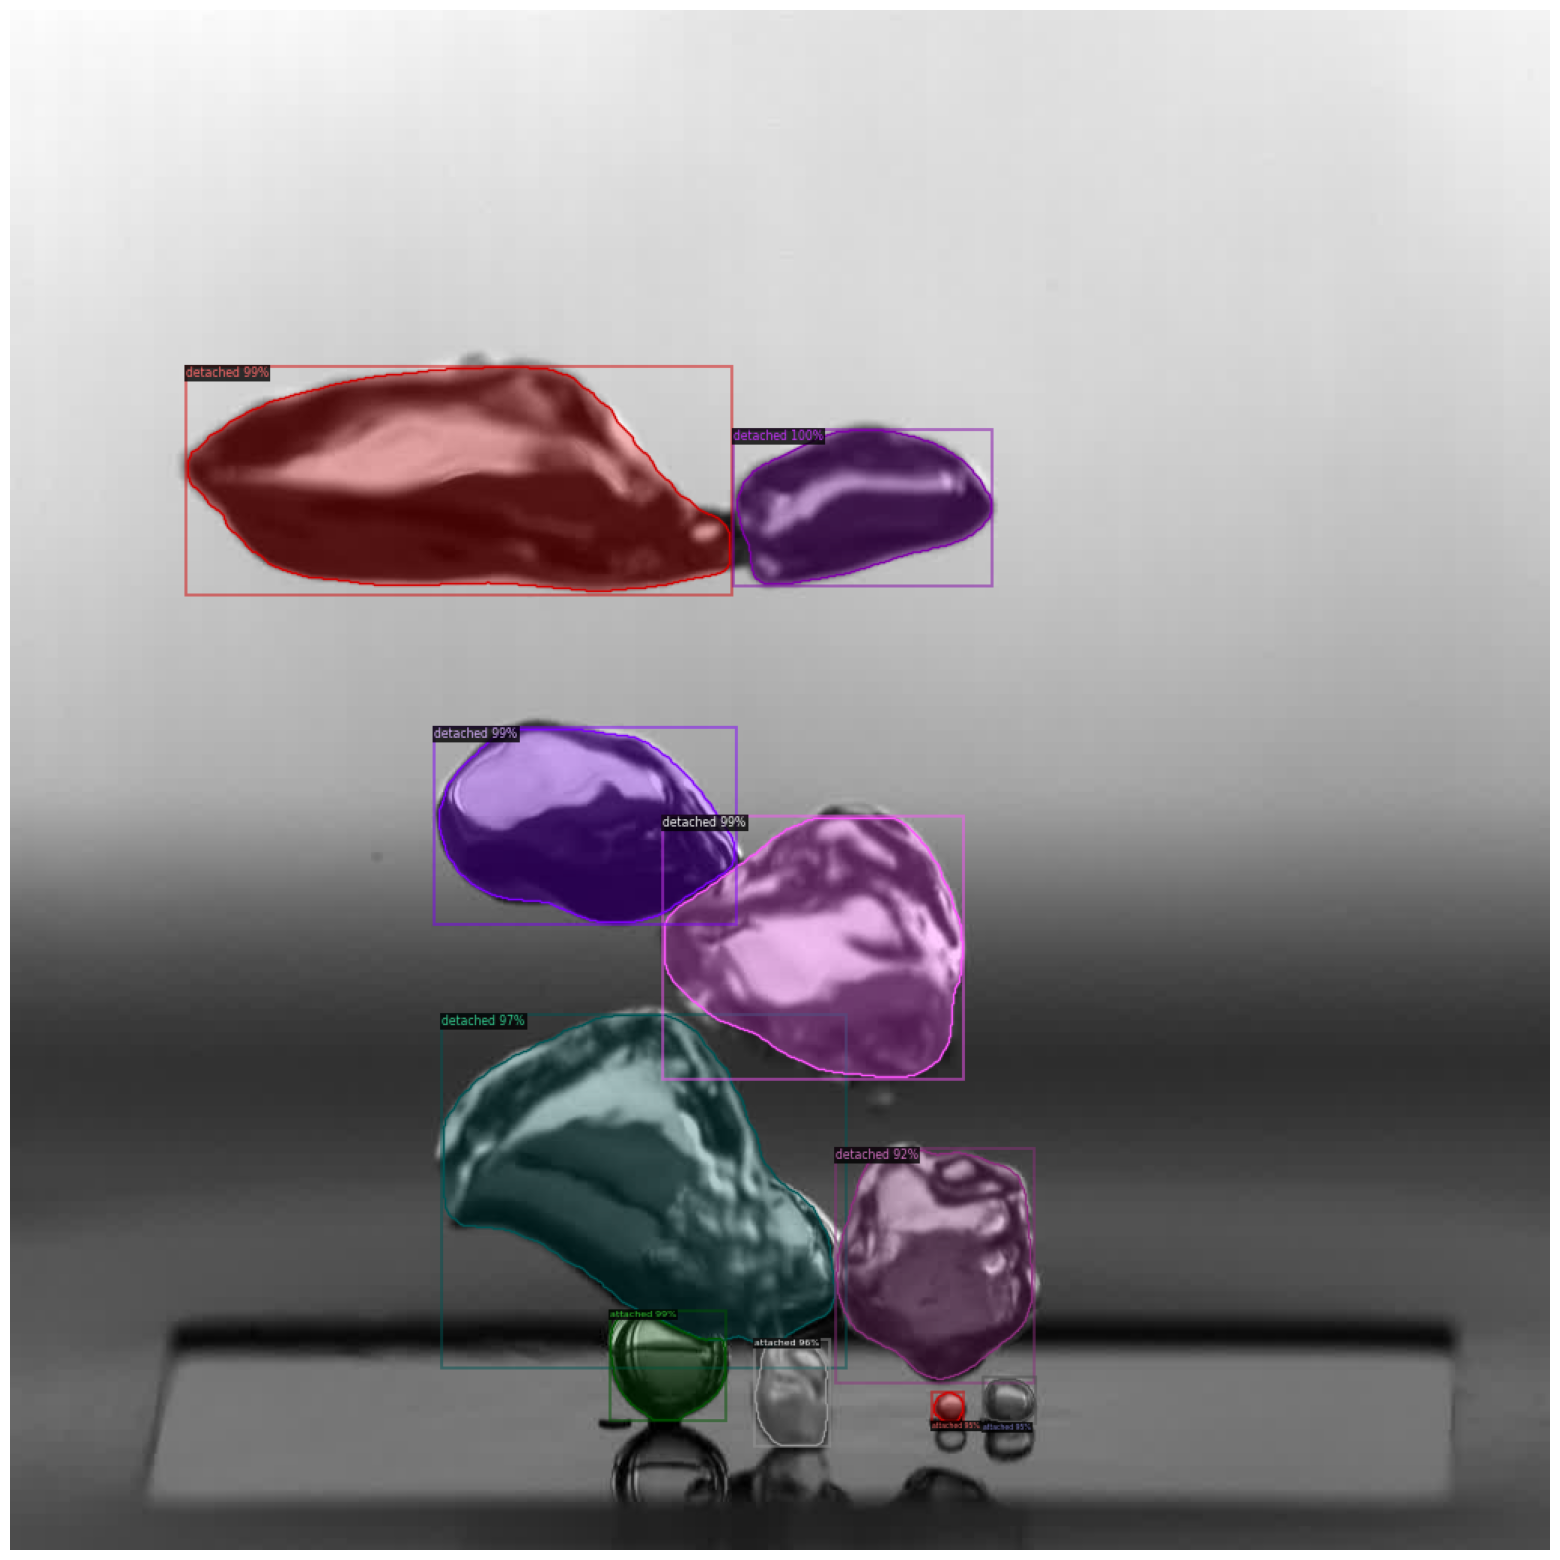

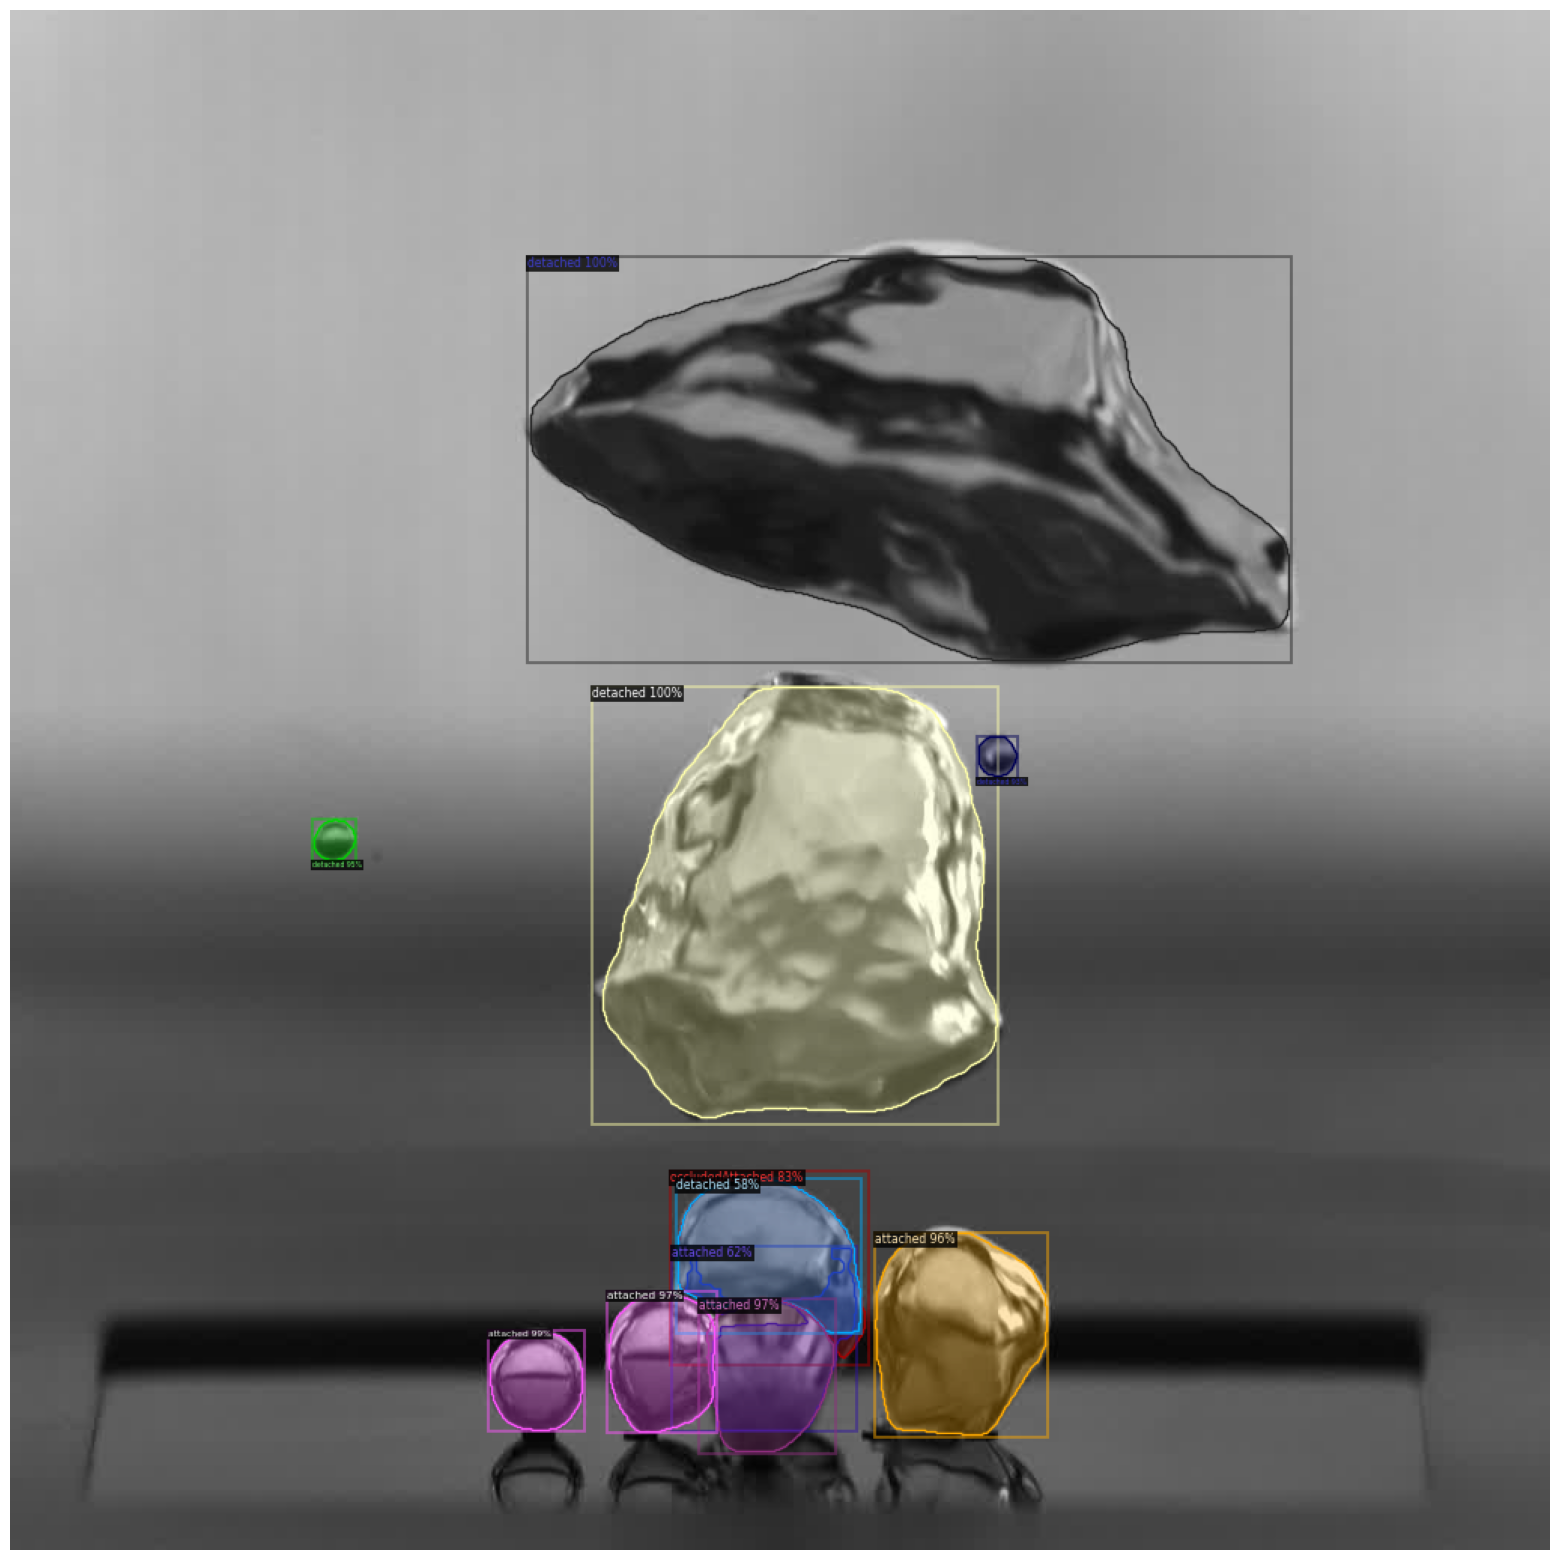

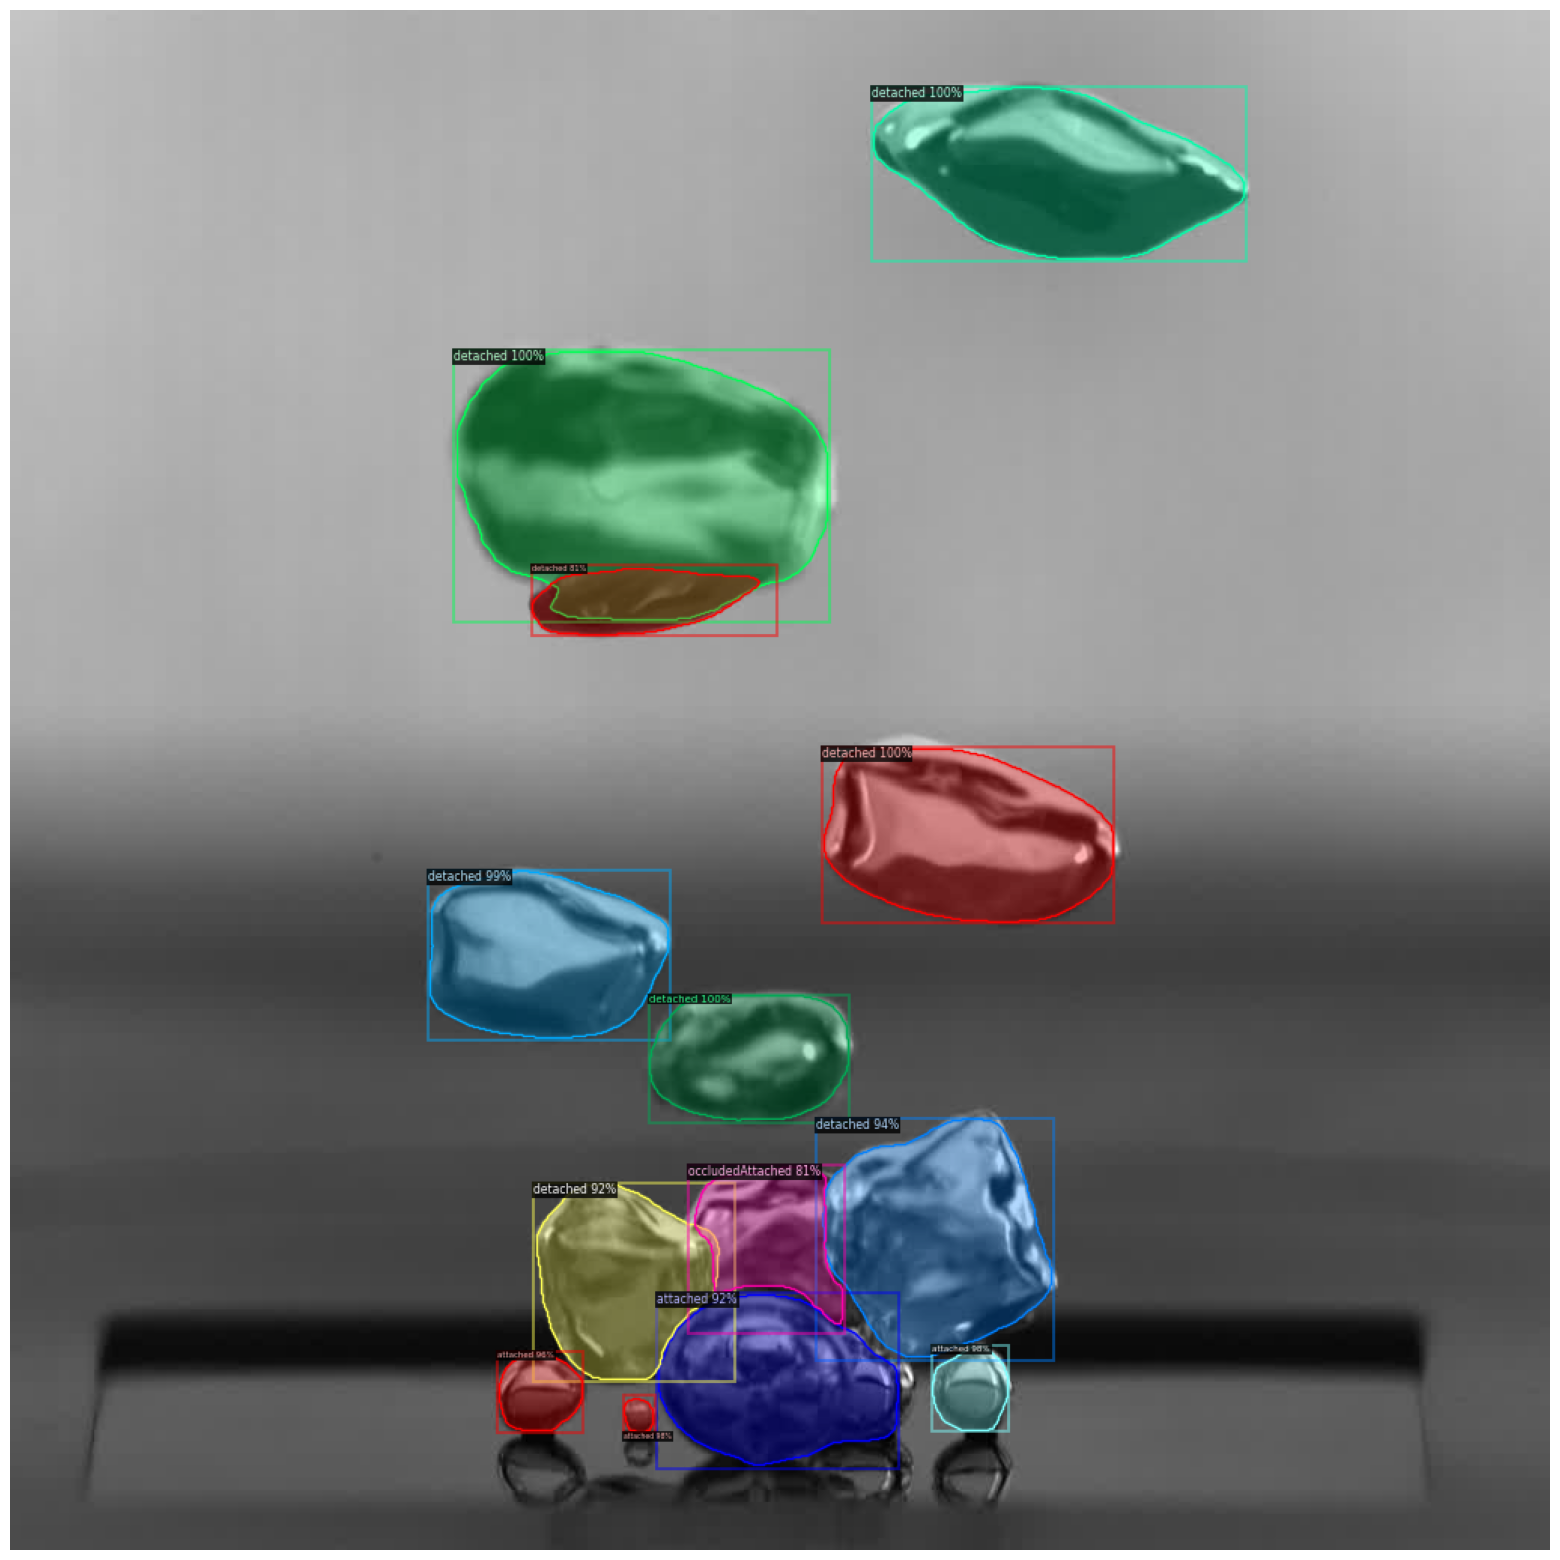

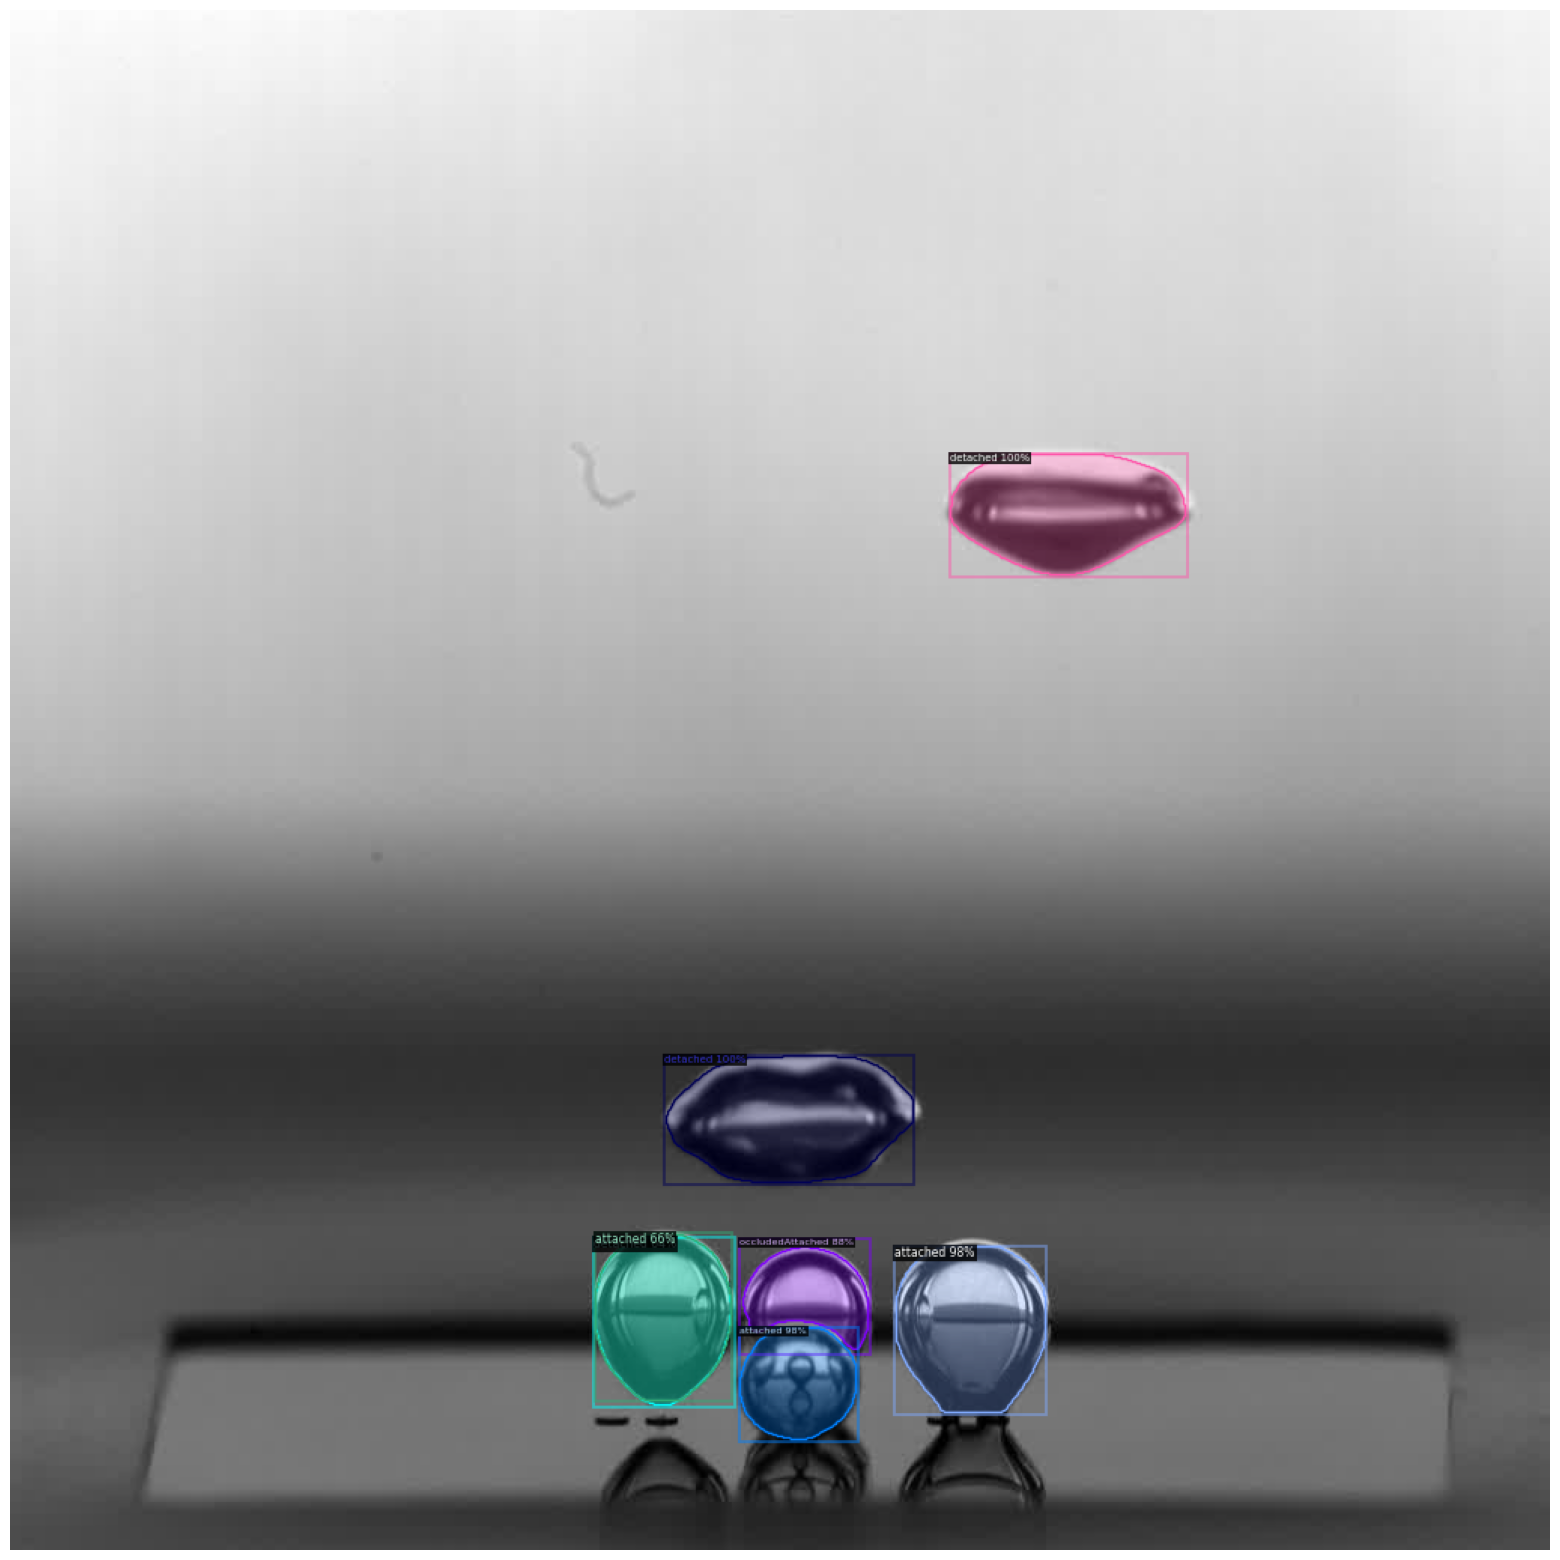

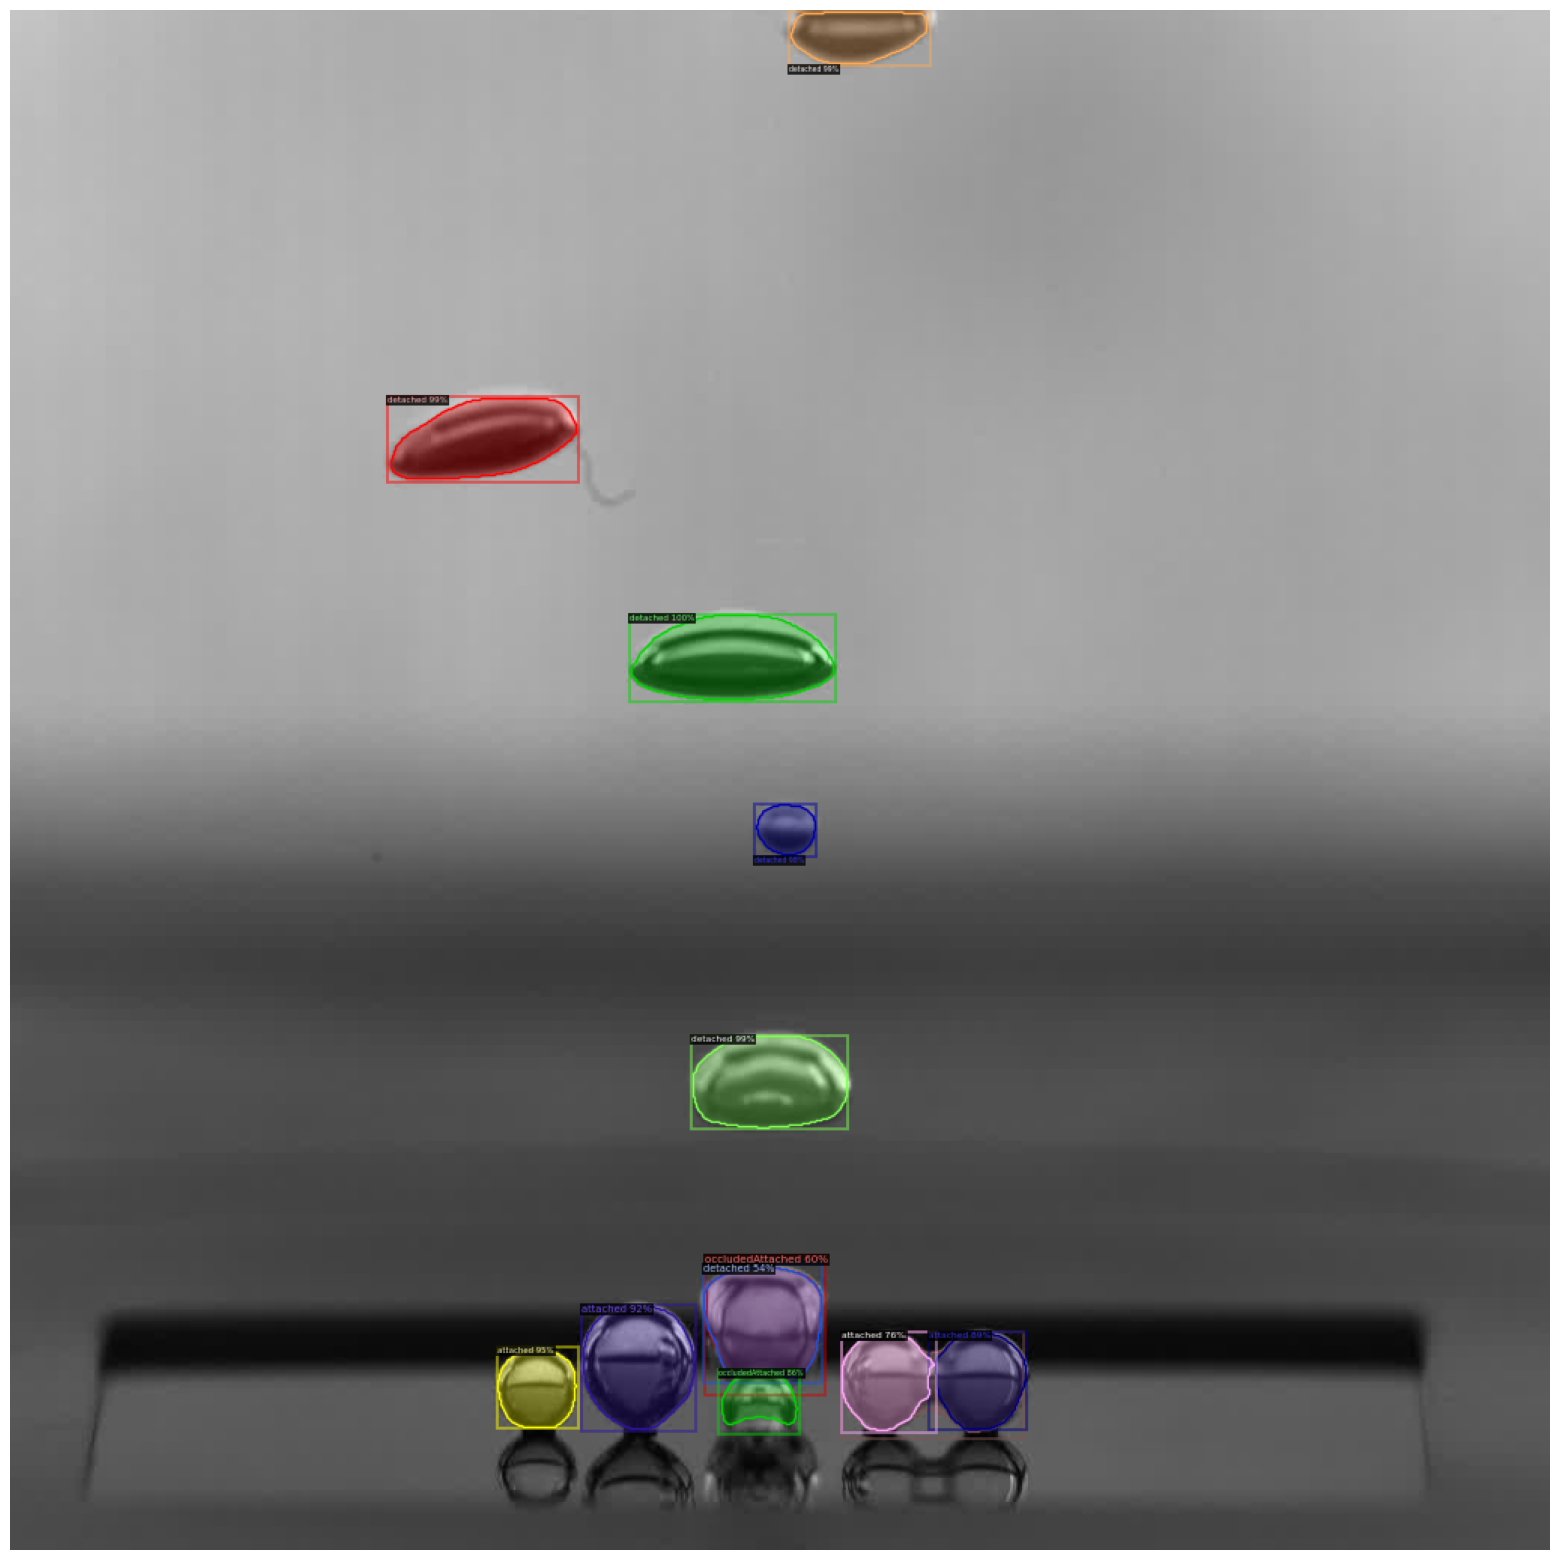

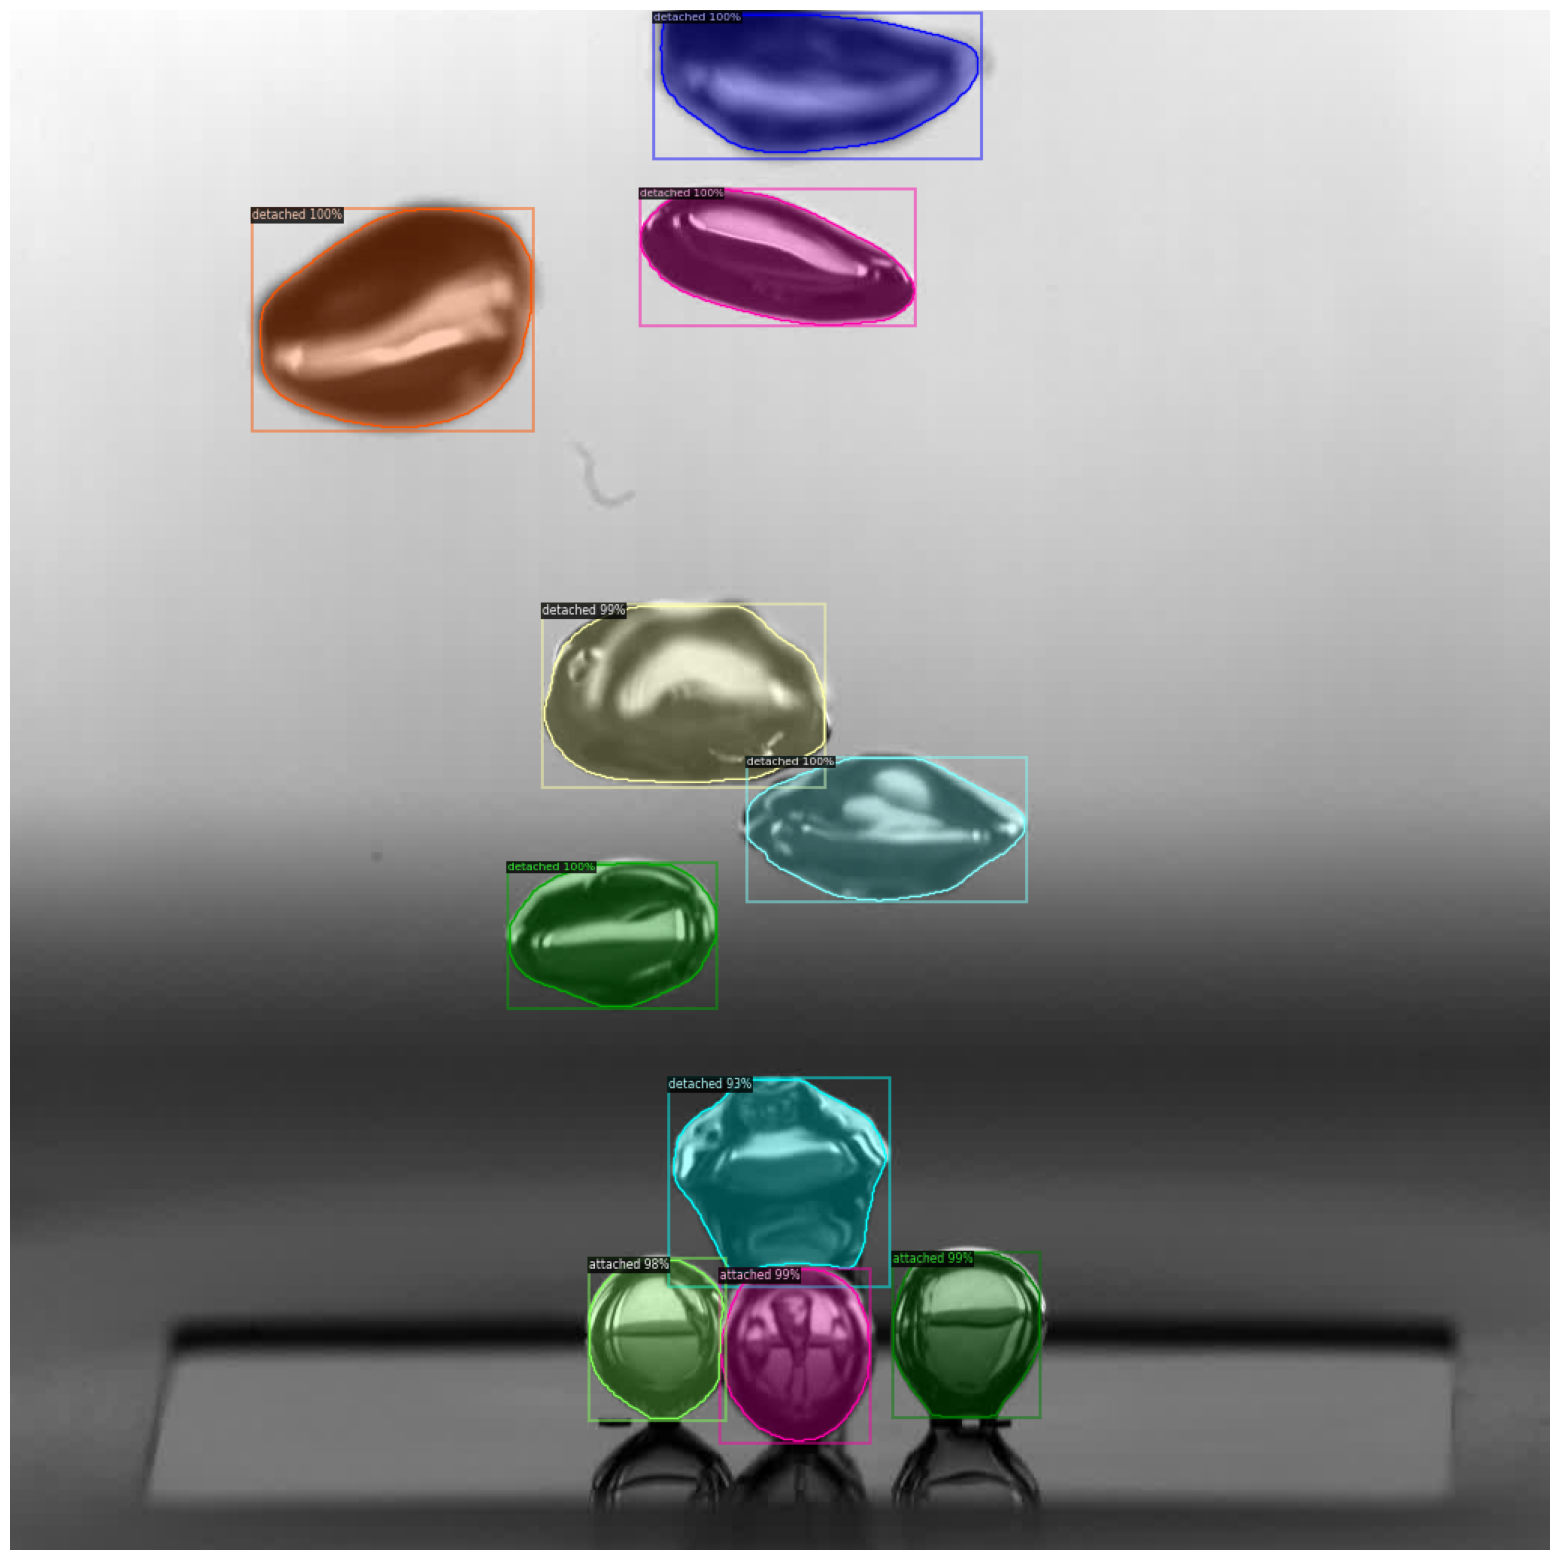

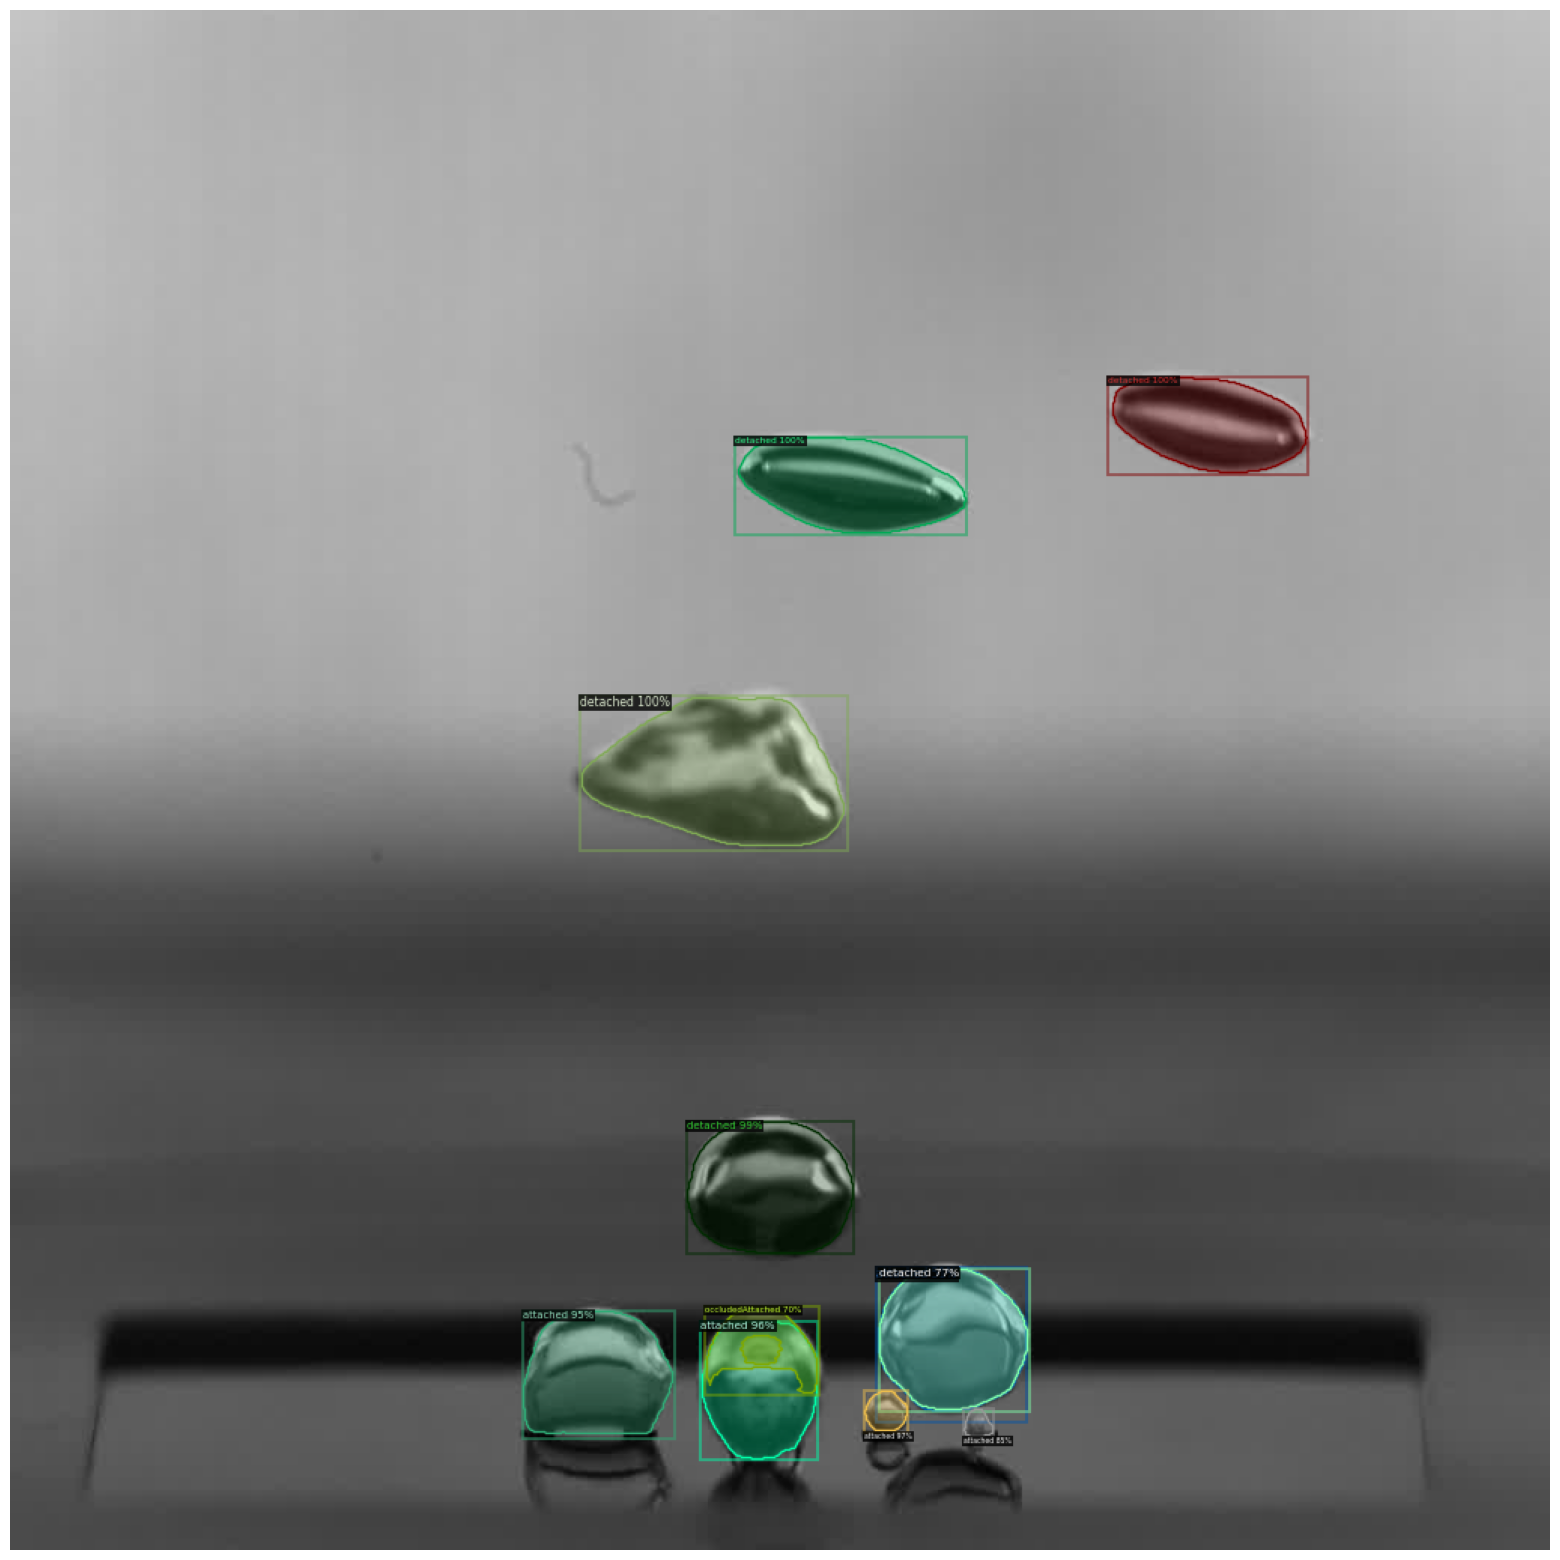

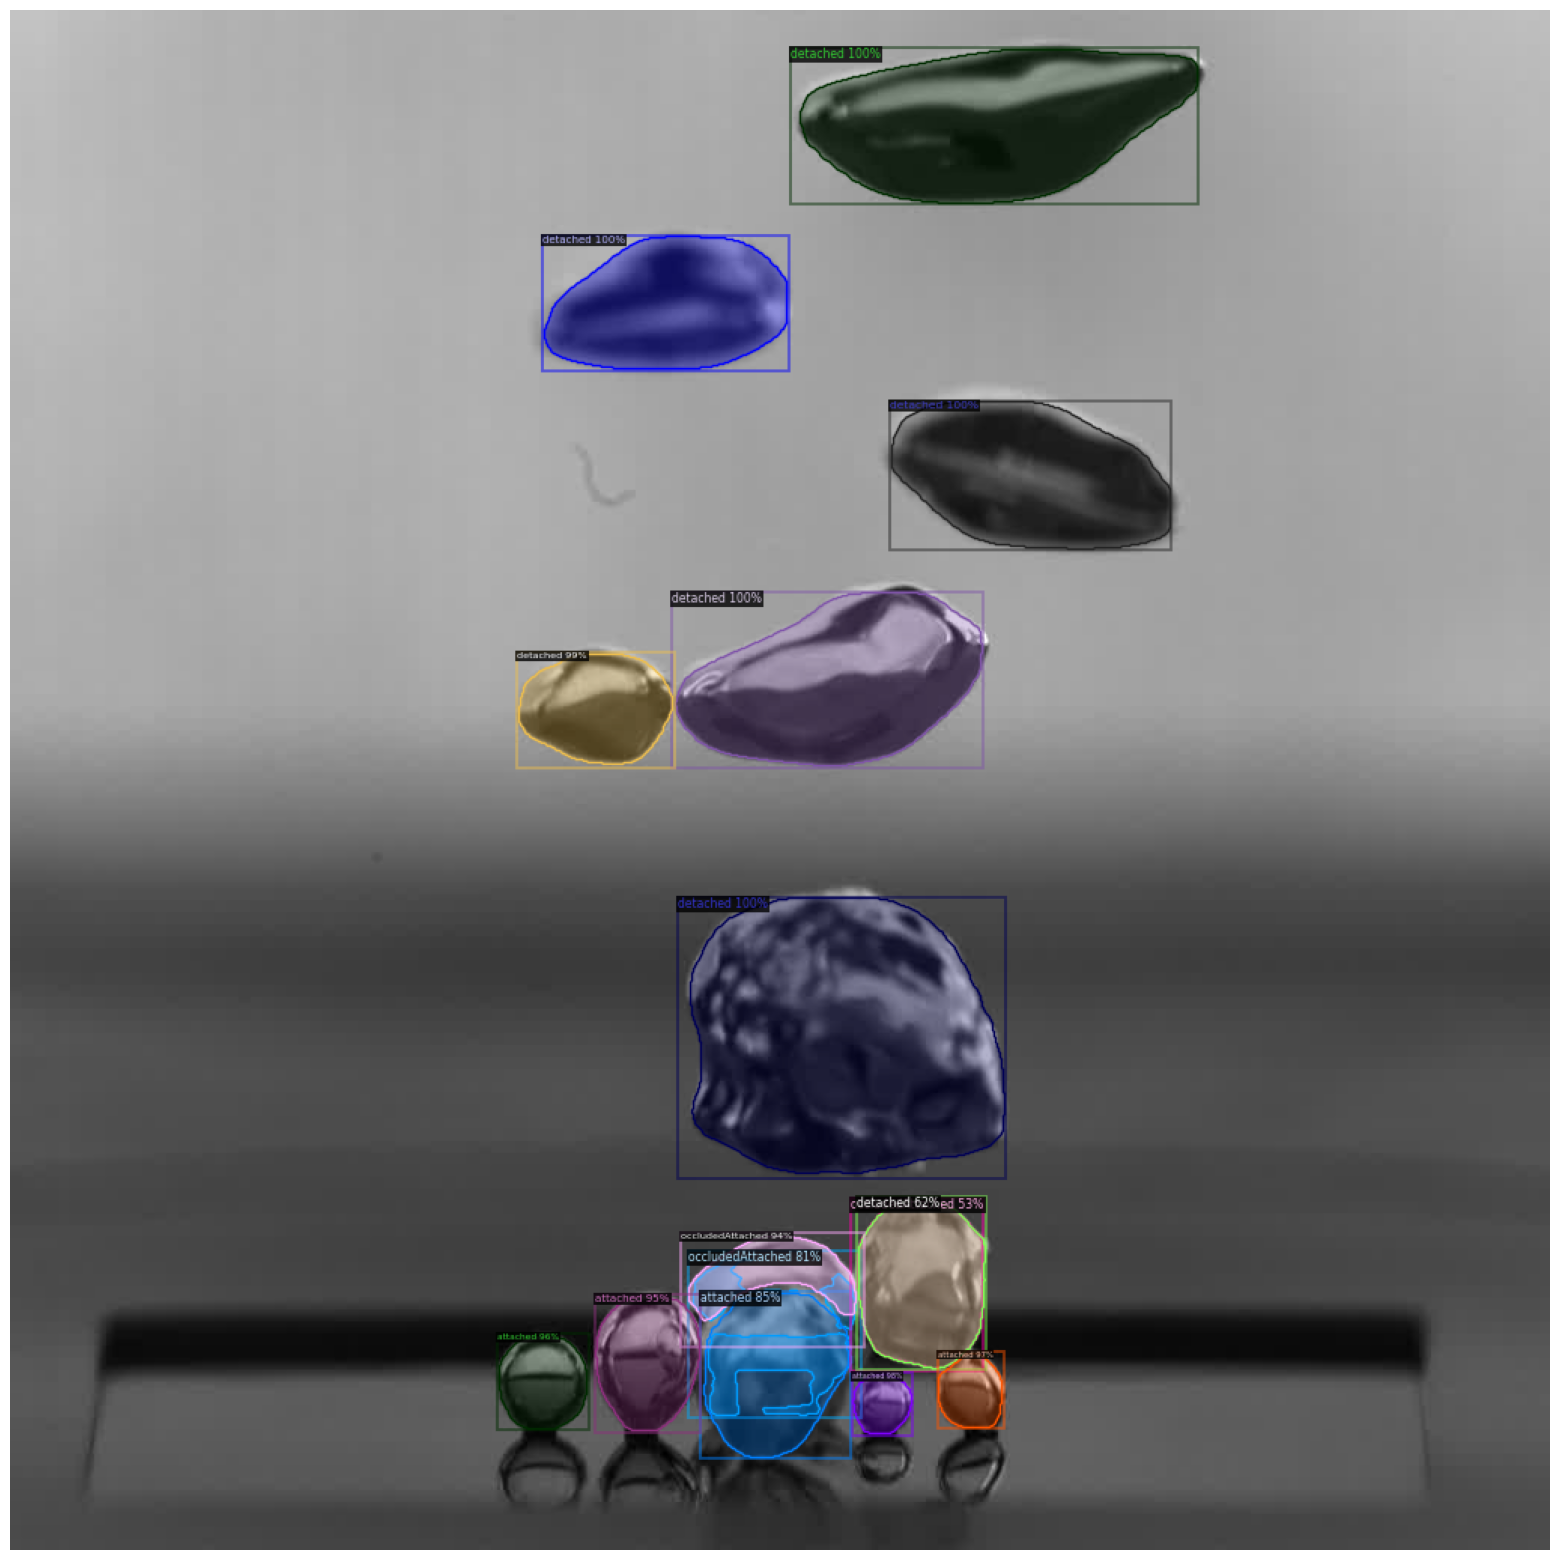

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


for d in random.sample(val_dataset_dicts, 10):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW,   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   font_size_scale = 0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20, 20))  # créer une nouvelle figure
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')              # pour enlever les axes
    plt.show()
    

## Average precision

In [14]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # ou ton nombre de classes
cfg.MODEL.DEVICE = "cuda"

# Ancien modèle
cfg.MODEL.WEIGHTS = "Models_3classes_all/model_final.pth"
predictor_old = DefaultPredictor(cfg)

# Nouveau modèle
cfg.MODEL.WEIGHTS = "Models_3classes/model_final.pth"
predictor_new = DefaultPredictor(cfg)


from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")



metrics_old = inference_on_dataset(predictor_old.model, val_loader, evaluator)
print("Ancien modèle :", metrics_old)

metrics_new = inference_on_dataset(predictor_new.model, val_loader, evaluator)
print("Nouveau modèle :", metrics_new)


[10/15 09:52:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Models_3classes_all/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (12, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) in th

[10/15 09:52:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Models_3classes/model_final.pth ...
WARNING [10/15 09:52:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/15 09:52:34 d2.data.datasets.coco]: Loaded 56 images in COCO format from dataset_tip\val.json
[10/15 09:52:34 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |   category    | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|  attached  | 217          |  detached  | 313          | occludedAtt.. | 47           |
|            |              |            |              |               |              |
|   total    | 577          |            |              |               |              |
[10/15 09:52:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in 